In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
from functions.evolutionaryalgo import quadratic_loss_function
from functions.inequality import gini, lorenz_curve
from distribution_model import *
import statsmodels.api as sm
from SALib.sample import latin
from matplotlib import style
from collections import OrderedDict
from functions.indirect_calibration import distr_model_performance
import seaborn as sns
import scipy.stats as stats
import scipy

In [2]:
style.use('ggplot')

In [3]:
NRUNS = 1

## Get parameters from calibration

In [4]:
pickle_in = open("nm_calibration_result.pickle","rb")
calibration_result = pickle.load(pickle_in)
print(calibration_result[0]['xopt'])
print(['trader_sample_size', 'std_noise', 'w_fundamentalists', 'w_momentum',
                      'init_stocks', 'base_risk_aversion', 'horizon'])

UnicodeDecodeError: 'ascii' codec can't decode byte 0x94 in position 0: ordinal not in range(128)

In [5]:
# convert relevant parameters to integers
integer_var_locations = [0, 4, 6]
new_input_params = []
for idx, par in enumerate(calibration_result[0]['xopt']):
    if idx in integer_var_locations:
        new_input_params.append(int(par))
    else:
        new_input_params.append(par.item())

In [6]:
uncertain_parameters = dict(zip(['trader_sample_size', 'std_noise', 'w_fundamentalists', 'w_momentum',
                      'init_stocks', 'base_risk_aversion', 'horizon'], new_input_params))
params = {"ticks": 10235, "fundamental_value": 166, 'n_traders': 1000, 'std_fundamental': 0.0530163128919286,
              'spread_max': 0.004087, "w_random": 1.0, "trades_per_tick": 4}
params.update(uncertain_parameters)
params

{'base_risk_aversion': 13.04209230587413,
 'fundamental_value': 166,
 'horizon': 26,
 'init_stocks': 17,
 'n_traders': 1000,
 'spread_max': 0.004087,
 'std_fundamental': 0.0530163128919286,
 'std_noise': 0.20813277184315787,
 'ticks': 10235,
 'trader_sample_size': 26,
 'trades_per_tick': 4,
 'w_fundamentalists': 47.61067793142201,
 'w_momentum': 55.01524438775738,
 'w_random': 1.0}

In [30]:
params = {'base_risk_aversion': 13.04209230587413,
 'fundamental_value': 166,
 'horizon': 26,
 'init_stocks': 17,
 'n_traders': 1000,
 'spread_max': 0.004087,
 'std_fundamental': 0.0530163128919286,
 'std_noise': 0.20813277184315787,
 'ticks': 5235,
 'trader_sample_size': 26,
 'w_fundamentalists': 47.61067793142201,
 'w_momentum': 10.01524438775738, 'trades_per_tick': 4,
 'w_random': 1.0}

In [31]:
params['w_fundamentalists'] = 10.0
params['fundamentalist_horizon_multiplier'] = 0.2 
params["mutation_probability"] = 0.4
params["average_learning_ability"] = 1.0

params

{'base_risk_aversion': 13.04209230587413,
 'fundamental_value': 166,
 'horizon': 26,
 'init_stocks': 17,
 'n_traders': 1000,
 'spread_max': 0.004087,
 'std_fundamental': 0.0530163128919286,
 'std_noise': 0.20813277184315787,
 'ticks': 5235,
 'trader_sample_size': 26,
 'w_fundamentalists': 10.0,
 'w_momentum': 10.01524438775738,
 'trades_per_tick': 4,
 'w_random': 1.0,
 'fundamentalist_horizon_multiplier': 0.2,
 'mutation_probability': 0.4,
 'average_learning_ability': 1.0}

## Run model

In [32]:
trdrs = []
obs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    obs.append(orderbook)

Start of simulation  0


# Price dynamics

In [35]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(obs, burn_in_period=0)

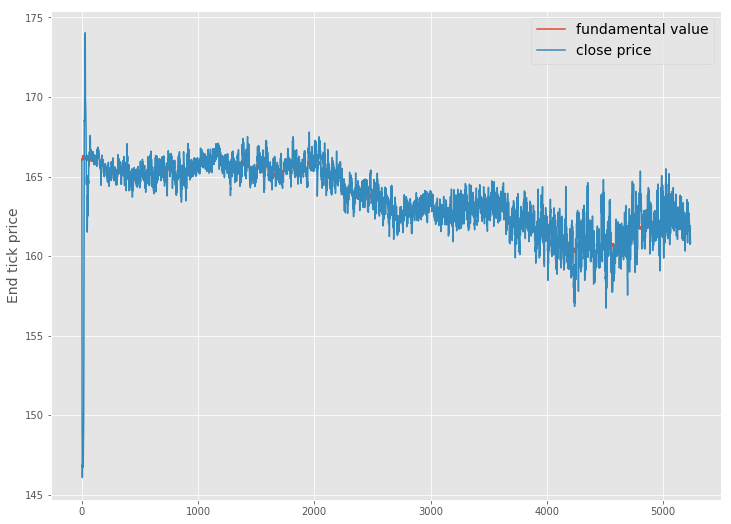

In [36]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,9))

ax1.plot(mc_fundamentals.index, mc_fundamentals[0], label='fundamental value')
ax1.plot(mc_prices.index, mc_prices[0], label='close price')

ax1.set_ylabel('End tick price', fontsize='14')
ax1.legend(loc='best', fontsize='14')

#fig.savefig('behavioural_hypothesis.png')

## Expectation dynamics

In [37]:
fundamentalist_component_at_t = 0
for x in trdrs[0]:
    fundamentalist_component_at_t += np.array(x.var.weight_fundamentalist) * x.var.forecast_adjust

In [38]:
fundamentalist_components = [np.array(x.var.weight_fundamentalist) * x.var.forecast_adjust for x in trdrs[0]]
chartist_components = [np.array(x.var.weight_chartist) * x.var.forecast_adjust for x in trdrs[0]]
random_components = [np.array(x.var.weight_random) * x.var.forecast_adjust for x in trdrs[0]]

In [39]:
fundamentalist_sentiment = sum(fundamentalist_components)
chartist_sentiment = sum(chartist_components)
random_sentiment = sum(random_components)
total_sentiment = fundamentalist_sentiment + chartist_sentiment + random_sentiment

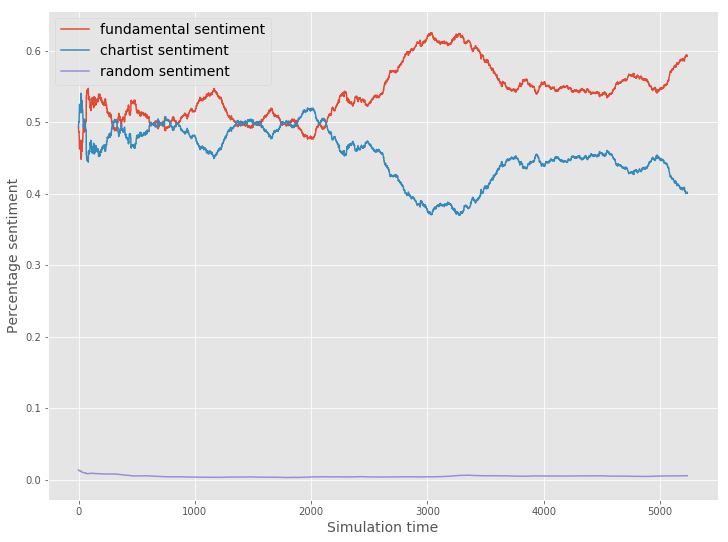

In [41]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,9))

ax1.plot(range(len(fundamentalist_sentiment)), fundamentalist_sentiment / total_sentiment, label='fundamental sentiment')
ax1.plot(range(len(chartist_sentiment)), chartist_sentiment / total_sentiment, label='chartist sentiment')
ax1.plot(range(len(random_sentiment)), random_sentiment / total_sentiment, label='random sentiment')

ax1.set_xlabel('Simulation time', fontsize='14')
ax1.set_ylabel('Percentage sentiment', fontsize='14')
ax1.legend(loc='best', fontsize='14')

fig.savefig('market_sentiment.png')

## Distributional dynamics

I am interested in the following distributions:

* wealth
* stocks
* money

I am interested in the following properties of the wealth distribution

1. Gini coefficient & Lorenz curve
2. Skew? 
3. Kurtosis? 
4. Concentration curves? 

### Money

In [42]:
# at the end of the simulation
money_holdings = np.array([x.var.money[-1] for x in trdrs[0]])

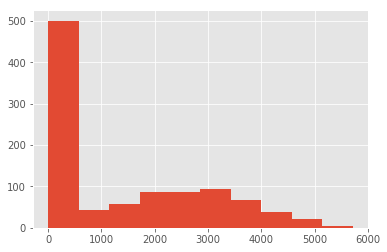

In [43]:
pd.Series(np.sort(money_holdings)).hist()

In [44]:
gini(money_holdings)

0.5771451637840386

Gini Evolution over time

In [45]:
money_gini_over_time = []
for t in range(params['ticks']):
    #print(t)
    money = np.array([x.var.money[t] for x in trdrs[0]])
    money_gini_over_time.append(gini(money))

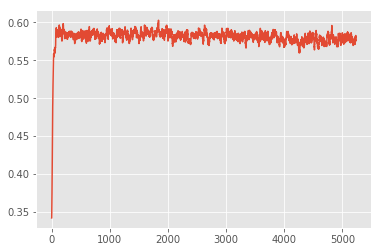

In [46]:
pd.Series(money_gini_over_time).plot()

### The distribution of Wealth
Wealth is measured as trader money + trader stock * price 

In [47]:
money = np.array([x.var.money[-1] for x in trdrs[0]])
stocks = np.array([x.var.stocks[-1] for x in trdrs[0]])
wealth = money + (stocks * mc_prices[0].iloc[-1])
#n, bins, patches = plt.hist(wealth, 50, density=True, alpha=0.75)

In [48]:
start_money = np.array([x.var.money[0] for x in trdrs[0]])
start_stocks = np.array([x.var.stocks[0] for x in trdrs[0]])
start_wealth = start_money + (start_stocks * mc_prices[0].iloc[0])

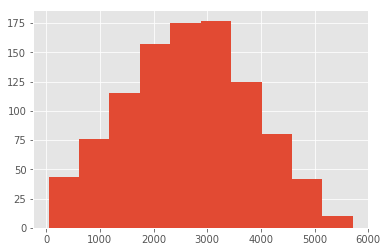

In [49]:
pd.Series(np.sort(wealth)).hist()

### Descriptives

In [50]:
pd.Series(wealth).describe()

count    1000.000000
mean     2654.100838
std      1170.292465
min        44.040314
25%      1816.304332
50%      2662.289447
75%      3473.181434
max      5714.961837
dtype: float64

Skewness and Kurtosis

In [51]:
print('Start of simulation skewness is ', pd.Series(start_wealth).skew())
print('End of simulation skewness is ', pd.Series(wealth).skew())
print('-----')
print('Start of simulation Kurtosis is ', pd.Series(start_wealth).kurtosis())
print('End of simulation Kurtosis is ', pd.Series(wealth).kurtosis())

Start of simulation skewness is  0.02468337675339858
End of simulation skewness is  0.008522500161649228
-----
Start of simulation Kurtosis is  -0.651269426439784
End of simulation Kurtosis is  -0.5379684062812049


### Ratios

#### Palma ratio
It is the ratio of national income shares of the top 10 per cent of
households to the bottom 40 per cent.

In [52]:
share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
print('Share top 10 is ', share_top_10)
share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
print('Share bottom 40 is ', share_bottom_40)

Share top 10 is  0.1758256605189994
Share bottom 40 is  0.22516700946782692


In [53]:
palma = share_top_10 / share_bottom_40
print('Palma ratio is ', palma)

Palma ratio is  0.780867769814753


### 20/20 ratio
Compares the ratio of the average income of the richest 20
per cent of the population to the average income of the poorest
20 per cent of the population.

In [54]:
share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
print('Average wealth top 20 is ', share_top_20)
share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
print('Average wealth bottom 20 is ', share_bottom_20)
twenty_twenty = share_top_20 / share_bottom_20
print('20/20 ratio is ', twenty_twenty)

Average wealth top 20 is  4297.648557791053
Average wealth bottom 20 is  998.4398228837271
20/20 ratio is  4.304364128203982


### Cumulative distribution

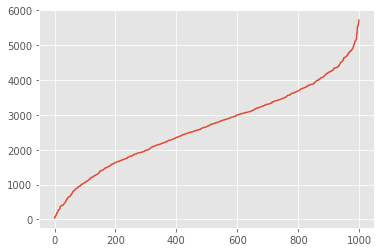

In [55]:
pd.Series(np.sort(wealth)).plot()

## Lorenz curve and Gini coefficient 

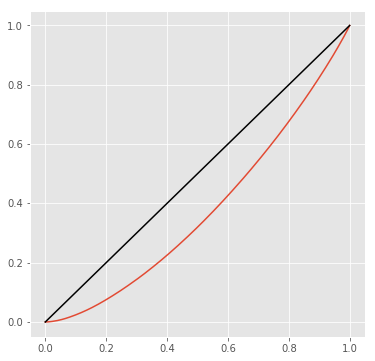

In [56]:
lorenz_curve(np.sort(wealth))

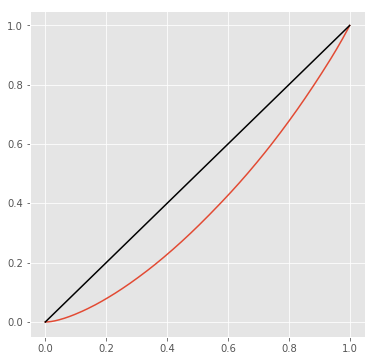

In [57]:
lorenz_curve(np.sort(start_wealth))

In [58]:
wealth_gini_over_time = []
palma_over_time = []
twentytwenty_over_time = []
for t in range(params['ticks']):
    #print(t)
    money = np.array([x.var.money[t] for x in trdrs[0]])
    stocks = np.array([x.var.stocks[t] for x in trdrs[0]])
    wealth = money + (stocks * obs[0].tick_close_price[t])
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palma_over_time.append(share_top_10 / share_bottom_40)
    
    share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
    share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
    twentytwenty_over_time.append(share_top_20 / share_bottom_20)
    
    wealth_gini_over_time.append(gini(wealth))

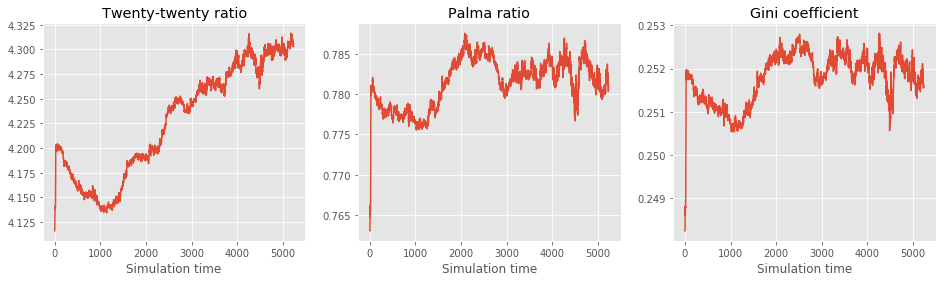

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[16,4])

ax1.plot(range(len(twentytwenty_over_time)), twentytwenty_over_time)
ax2.plot(range(len(palma_over_time)), palma_over_time)
ax3.plot(range(len(wealth_gini_over_time)), wealth_gini_over_time)

ax1.set_title('Twenty-twenty ratio')
ax2.set_title('Palma ratio')
ax3.set_title('Gini coefficient')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Simulation time')

fig.savefig('gini_palma_twenty_evolution.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Correlation curves and coefficients

### Concentration curves

The concentration curve plots the cumulative percentage of the a variable of interest (y-axis) against the cumulative percentage of the sample, ranked by wealtht, beginning with poorest agents , and ending with the richest agents (x-axis) (source: World Bank).

The items of interest are: 
1. risk aversion,
2. relative weight of chartism
3. relative weight of fundamentalism
4. relative weight of chartism vs. fundamentalism
5. horizon

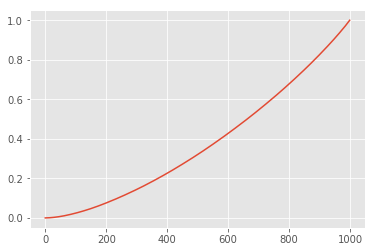

In [60]:
pd.Series(np.cumsum(np.sort(wealth) / sum(wealth))).plot()

In [62]:
# TODO somewhere here, I should modify the vars to take into account multiple seeds
risk_aversion = np.array([x.par.risk_aversion for x in trdrs[0]])
weight_chart = np.array([x.var.weight_chartist * x.var.forecast_adjust for x in trdrs[0]])
weight_fund = np.array([x.var.weight_fundamentalist * x.var.forecast_adjust for x in trdrs[0]])
horizon = np.array([float(x.par.horizon) for x in trdrs[0]])

c_curve_data = pd.DataFrame({'wealth': (wealth / sum(wealth)), 
                             'risk_aversion': (risk_aversion / sum(risk_aversion)), 
                             'weigth_chart': (weight_chart / sum(weight_chart)), 
                             'weight_fundamental': (weight_fund / sum(weight_fund)), 
                             'horizon': (horizon / sum(horizon))})

c_curve_data = c_curve_data.sort_values('wealth')
# need rank based on fractional rank

TypeError: can't multiply sequence by non-int of type 'float'

If a curve is above the equality line, this indicates that agents which have a large amount of that variable are more likely to be poor?  

NameError: name 'c_curve_data' is not defined

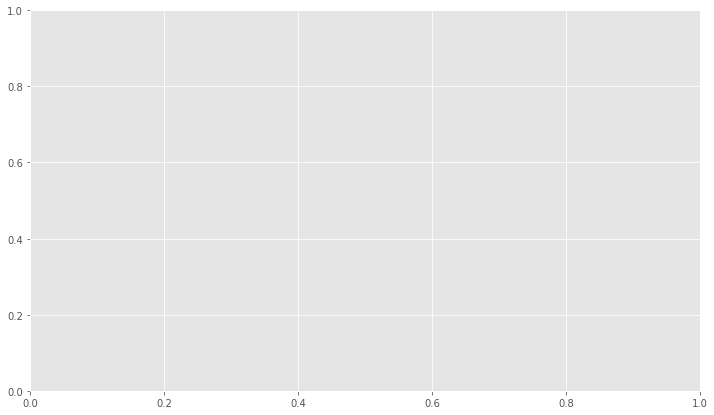

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))

ax.plot(np.cumsum(c_curve_data['wealth']), np.cumsum(c_curve_data['risk_aversion']), label='x = risk aversion')
ax.plot(np.cumsum(c_curve_data['wealth']), np.cumsum(c_curve_data['weigth_chart']), label='x = chartist weight')
ax.plot(np.cumsum(c_curve_data['wealth']), np.cumsum(c_curve_data['weight_fundamental']), label='x = fundamentalist weight')
ax.plot(np.cumsum(c_curve_data['wealth']), np.cumsum(c_curve_data['horizon']), label='x = horizon') # this doesn't really work yet 
ax.plot([0,1], [0,1], 'k--', label='line of equality')

ax.set_ylabel('Cumulative percentage x', fontsize=14)
ax.set_xlabel('Cumulative percentage of Wealth', fontsize=14)
ax.legend(fontsize=14, loc='best')

fig.savefig('concentration_curves.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

The concentration index is defined as twice the area between the concentration curve and the line of equality (the 45-degree line) (source: WB). The convention is that the index takes a negative value when the curve lies above the line of equality, indicating disproportionate concentration of the variable of interest among the poor, and a positive value when it lies below the line of equality. **Therefore, a negative value of the index shows that more poor agents have that property and vice versa.** 

It can be calculated as follows:

$C = \frac{2}{\bar{x}} cov(x, r)$

where $x$ is the variable of interest, $\bar{x}$ it's average, and r its fractional rank in the wealth distribution. 

In [30]:
c_index_data = pd.DataFrame({'wealth': wealth, 
                             'risk_aversion': risk_aversion, 
                             'weigth_chart': weight_chart, 
                             'weight_fundamental': weight_fund, 
                             'horizon': horizon})

c_index_data['frac_rank'] = scipy.stats.rankdata(c_index_data['wealth'], method='average') / len(c_index_data['wealth'])

In [31]:
c_index_data.cov()

,wealth,risk_aversion,weigth_chart,weight_fundamental,horizon,frac_rank
wealth,3.408979e+08,-874.379415,-62.142105,48.749670,-18475.510548,1426.644892
risk_aversion,-8.743794e+02,6.964979,-0.006175,0.004802,-0.091411,0.216232
weigth_chart,-6.214210e+01,-0.006175,0.002665,-0.002090,0.004900,-0.003980
weight_fundamental,4.874967e+01,0.004802,-0.002090,0.001646,-0.004367,0.003126
horizon,-1.847551e+04,-0.091411,0.004900,-0.004367,21.503014,-0.176718
frac_rank,1.426645e+03,0.216232,-0.003980,0.003126,-0.176718,0.083417


In [32]:
def concentr_index(var_name):
    return (2 / c_index_data[var_name].mean()) * c_index_data.cov().loc[var_name]['frac_rank']

In [33]:
# TODO check if this is correct!
concentration_indexes = {key: concentr_index(key) for key in c_curve_data.columns}
pd.Series(concentration_indexes)

wealth                0.892049
risk_aversion         0.033011
weigth_chart         -0.010218
weight_fundamental    0.035380
horizon              -0.019837
dtype: float64

Doorslaer (2004) have shown that multiplying the value of the concentration index by 75 gives the percentage of the health variable that would need to be (linearly) redistributed from the richer half to the poorer half of the population (in the case that health inequality favors the rich) to arrive at a distribution with an index value of zero.